In [31]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.stats import uniform

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[7,5]

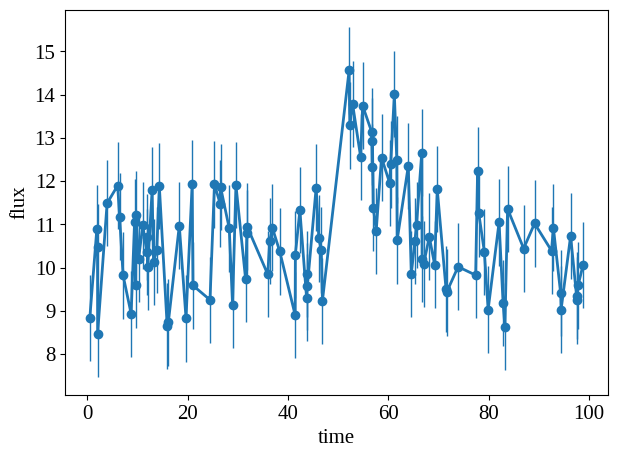

In [32]:
data=np.load('transient.npy')

time=data[:,0]
flux=data[:,1]
err=data[:,2]

plt.scatter(time, flux)
plt.errorbar(time, flux, err, lw=2, elinewidth=1)
plt.xlabel("time")
plt.ylabel("flux")
plt.show()

In [4]:
def model(par, time):
    b, A, t_0, alpha = par
    y=np.empty(len(time))
    for i in range(len(time)):
        if time[i]<t_0:
            y[i]=b
        else:
            y[i]=b + A * np.exp(-alpha*(time[i]-t_0)) 
    return y

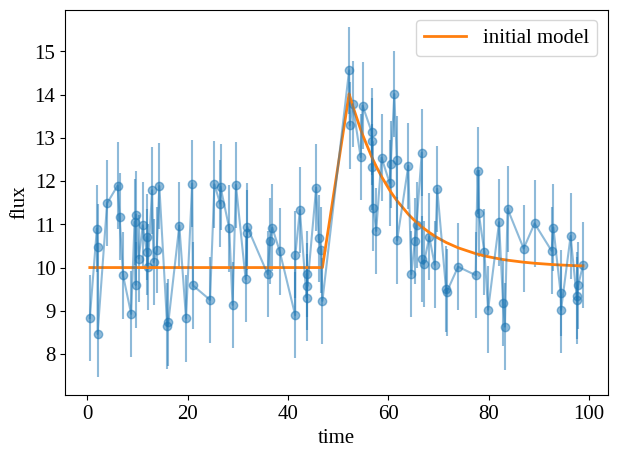

In [33]:
b, A, t_0, alpha = 10, 5, 50, 0.1
par = [b, A, t_0, alpha]

# fit the model with arbitrary parameter to search reasonably initial conditions
flux_model = model(par, time)

plt.scatter(time, flux, alpha=0.5)
plt.errorbar(time, flux, err, alpha=0.5)
plt.plot(time, flux_model, label='initial model', lw=2)
plt.legend()
plt.ylabel('flux')
plt.xlabel('time')
plt.show()

In [6]:
def logLikelihood(par, time, flux, err):
    b, A, t_0, alpha = par
    Model_y = model(par, time)
    return - 0.5 * np.sum((flux-Model_y)**2/(err**2))

def logPrior(par):
    b, A, t_0, alpha = par
    if 0 < b < 50 and 0 < A < 50 and 0 < t_0 < 100 and np.exp(-5) < alpha < np.exp(5):
        return np.log(1/alpha)
    return -np.inf

def logPosterior(par, time, flux, err):
    lp = logPrior(par)
    if np.isfinite(lp):
        return lp + logLikelihood(par, time, flux, err)
    return lp

In [7]:
ndim = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
burn = 2000  # "burn-in" period to let chains stabilize
nsteps = 25000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(123)
starting_guesses = par + np.random.randn(nwalkers, ndim)/100

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[time, flux, err])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

100%|████████████████████████████████████████████████████████| 25000/25000 [00:55<00:00, 449.14it/s]

done


In [8]:
print(starting_guesses)

[[ 9.98914369  5.00997345 50.00282978  0.08493705]
 [ 9.994214    5.01651437 49.97573321  0.09571087]
 [10.01265936  4.9913326  49.99321114  0.09905291]
 [10.0149139   4.99361098 49.99556018  0.09565649]
 [10.0220593   5.02186786 50.01004054  0.10386186]
 [10.00737369  5.01490732 49.99064166  0.11175829]
 [ 9.98746119  4.99362248 50.00907105  0.08571319]
 [ 9.99859931  4.99138245 49.99744381  0.07201411]
 [ 9.98228467  4.99300123 50.00927462  0.09826364]
 [10.00002846  5.00688223 49.99120464  0.10283627]
 [ 9.99194633  4.98272331 49.996091    0.10573806]
 [10.00338589  4.9998817  50.02392365  0.10412912]
 [10.00978736  5.02238143 49.98705915  0.08961212]
 [10.01743712  4.99201937 50.00029683  0.11069316]
 [10.00890706  5.01754886 50.01495644  0.11069393]
 [ 9.99227291  5.00794863 50.00314272  0.08673735]
 [10.01417299  5.00807237 50.0004549   0.09766908]
 [ 9.98801699  5.00199524 50.00468439  0.09168845]
 [10.01162204  4.98902797 49.978769    0.11039727]
 [ 9.99596634  4.9987397  49.99

In [9]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(20, 25000, 4)
(460000, 4)


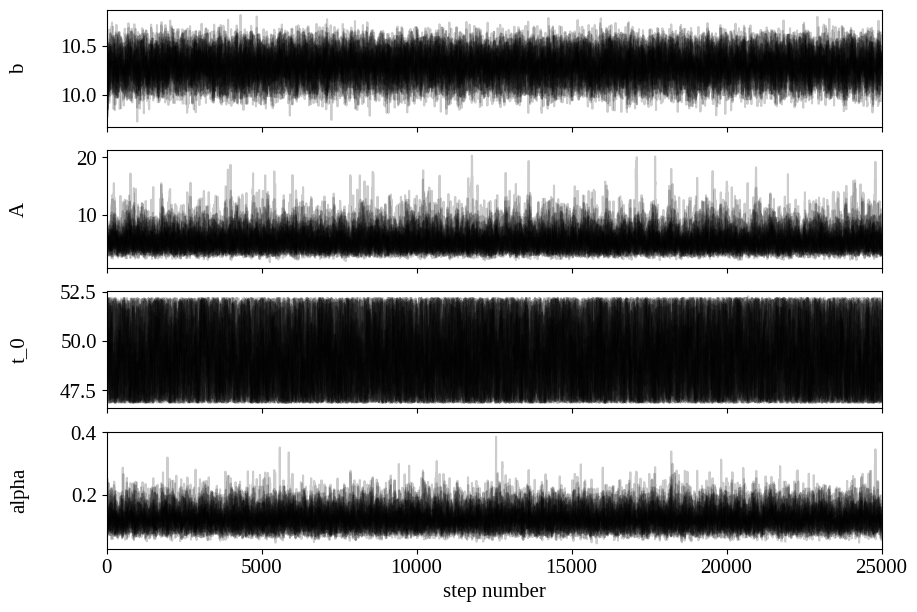

In [10]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b","A","t_0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.2, color = 'black')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

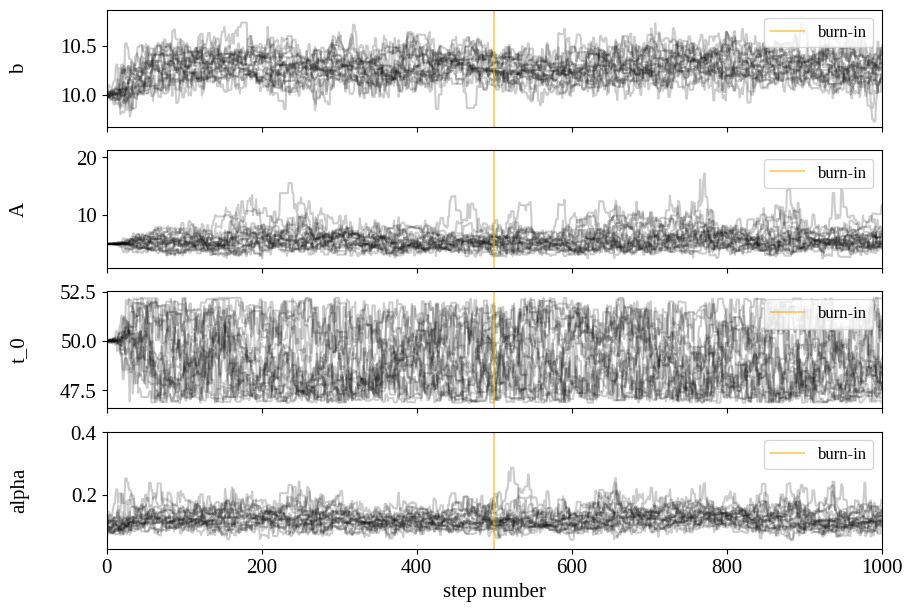

In [11]:
# check the start of the chain to decide the burn in and the autocorrelation lenght

burnin = 500   # remove the first points

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b","A","t_0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.2, color = 'black')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(burnin, color='orange', alpha=0.5, label='burn-in')
    ax.legend(loc='upper right', fontsize="12")

plt.xlim(0, 1000)
axes[-1].set_xlabel("step number");

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

[58.31367801 78.7984839  76.40499041 63.90136932]


In [13]:
corr_time = int(max(tau))

flat_samples = sampler.get_chain(discard=burnin, thin=corr_time, flat=True)
print(flat_samples.shape)

(6280, 4)


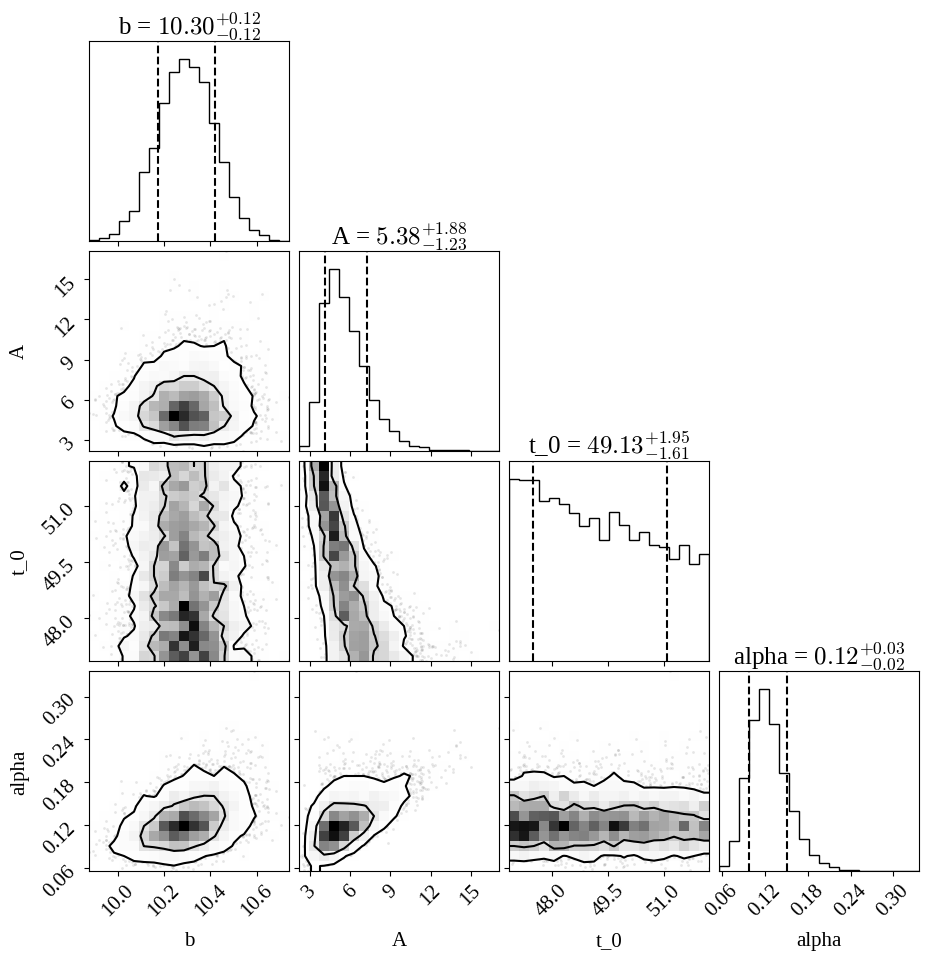

In [14]:
import corner

fig = corner.corner(flat_samples, labels=labels, levels=[0.68,0.95], quantiles=[0.16, 0.84], show_titles=True)

<ErrorbarContainer object of 3 artists>

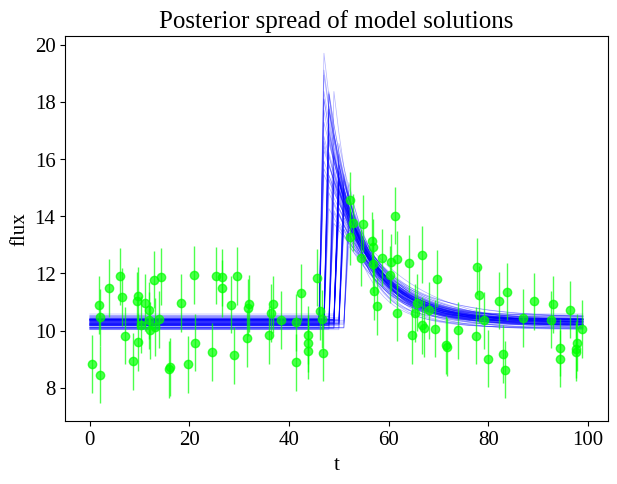

In [36]:
#choose 100 random sample

samples_100 = flat_samples[np.random.choice(range(len(flat_samples)), 100)]

t = np.linspace(0, 100, 100)
flux_mcmc = np.array([model(par, t) for par in samples_100])

for i in range(len(flux_mcmc)):
    plt.plot(flux_mcmc[i], alpha=0.3, color='blue', lw=0.5)
    plt.title('Posterior spread of model solutions')
    plt.xlabel('t')
    plt.ylabel('flux')
    
plt.errorbar(time, flux, err, lw=2, elinewidth=1, fmt='o', color='lime', alpha=0.7)

In [29]:
median=np.empty(ndim)
q_95=np.empty(ndim)
q_05=np.empty(ndim)

for i in range(ndim):
    median[i]=np.median(flat_samples[:, i])
    q_95[i]=np.quantile(flat_samples[:, i], 0.95)
    q_05[i]=np.quantile(flat_samples[:, i], 0.05)
    
    up = q_95[i]-median[i]        
    low = median[i]-q_05[i]
    
    print(labels[i], '=', str(round(median[i],2)),'+', str(round(up,2)), '-', str(round(low,2)))

b = 10.3 + 0.2 - 0.2
A = 5.38 + 3.48 - 1.78
t_0 = 49.13 + 2.71 - 2.05
alpha = 0.12 + 0.05 - 0.04


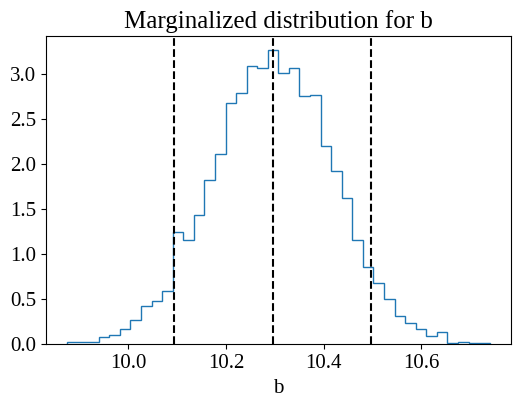

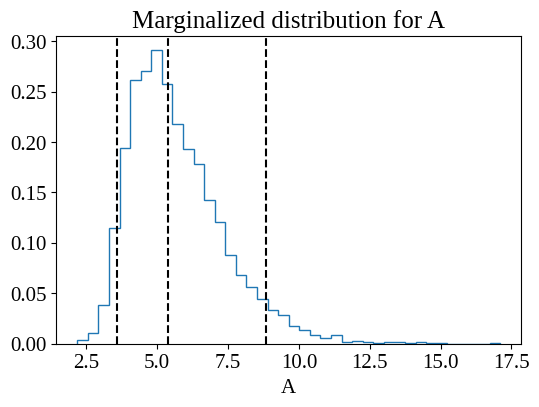

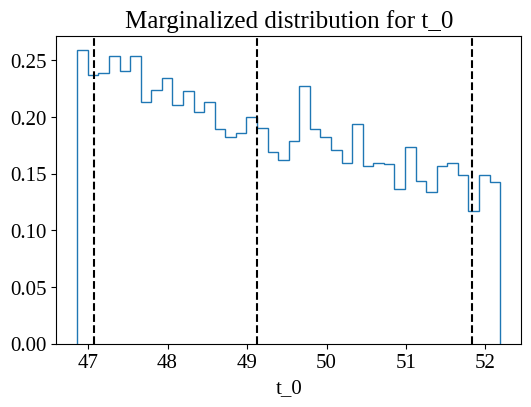

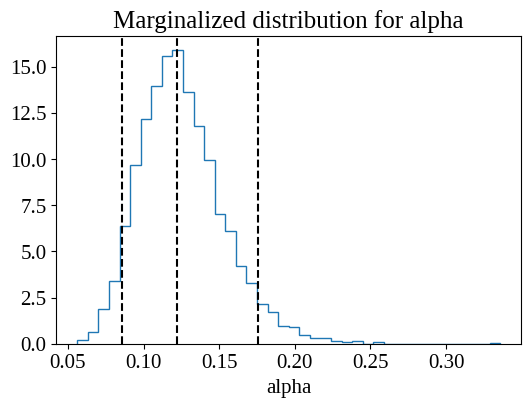

In [30]:
for i in range(ndim):
    plt.hist(flat_samples[:,i], bins=40, histtype='step', density=True)
    plt.axvline(median[i], color='black', linestyle='--')
    plt.axvline(q_95[i], color='black', linestyle='--')
    plt.axvline(q_05[i], color='black', linestyle='--')
    
    plt.title('Marginalized distribution for '+ labels[i])
    plt.xlabel(labels[i])
    
    plt.show()